In [1]:
!pip install gymnasium pettingzoo matplotlib seaborn > /dev/null 2>&1

In this Notebook, you have to implement both Independent Learners (which are basically Q-Learners, but since the setting is again stateless, the updates simplify since there is no discount factor and no next time step) and Joint-Action Learners (Claus & Boutilier, 1998) in some coordination games.

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt

import gymnasium as gym
from gymnasium import spaces
from pettingzoo import ParallelEnv

In [3]:
class Qlearner:
    """A Q-learning agent"""

    def __init__(
        self,
        action_size,
        state_size,
        learning_rate=0.0,
        gamma=0.95,
        epsilon=1.0,
        epsilon_min=0.01,
        epsilon_decay=0.995,
    ):
        self.action_size = action_size
        self.state_size = state_size

        # initialize the Q-table:
        self.qtable = np.zeros((self.state_size, self.action_size))

        # define learning rate:
        if learning_rate == 0.0:
            self.dynamic_lr = True
            self.action_counter = np.zeros((self.state_size, self.action_size))
        else:
            self.dynamic_lr = False
            self.learning_rate = learning_rate

        # discount factor:
        self.gamma = gamma

        # Exploration parameters:
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

        # tracking rewards/progress:
        self.rewards_this_episode = []  # during an episode, save every time step's reward
        self.episode_total_rewards = []  # each episode, sum the rewards, possibly with a discount factor
        self.average_episode_total_rewards = []  # the average (discounted) episode reward to indicate progress

        self.state_history = []
        self.action_history = []

    def reset_agent(self):
        self.qtable = np.zeros((self.state_size, self.action_size))

    def select_greedy(self, state):
        # np.argmax(self.qtable[state]) will select first entry if two or more Q-values are equal, but we want true randomness:
        return np.random.choice(np.flatnonzero(np.isclose(self.qtable[state], self.qtable[state].max())))

    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            action = random.randrange(self.action_size)
        else:
            action = self.select_greedy(state)
        self.state_history.append(state)
        self.action_history.append(action)
        return action

    def update_epsilon(self):
        self.epsilon *= self.epsilon_decay
        self.epsilon = max(self.epsilon_min, self.epsilon)

    def update(self, state, action, new_state, reward, done, update_epsilon=True):
        if not self.dynamic_lr:
            lr = self.learning_rate
        else:
            self.action_counter[state, action] += 1
            lr = 1 / self.action_counter[state, action]

        # Q(s,a) <-- Q(s,a) + learning_rate [R + gamma * max_a' Q(s',a') - Q(s,a)]
        # NOTE: in this case, you can safely remove self.gamma * np.max(self.qtable[new_state]), since the (not done) variable
        # before will always be 0, so it disappears. I left it in for uniformity of the code to other environments.
        self.qtable[state, action] += lr * (reward + (not done) * self.gamma * np.max(self.qtable[new_state]) - self.qtable[state, action])

        self.rewards_this_episode.append(reward)

        if done:
            # track total reward:
            episode_reward = self._calculate_episode_reward(self.rewards_this_episode, discount=False)
            self.episode_total_rewards.append(episode_reward)

            k = len(self.average_episode_total_rewards) + 1  # amount of episodes that have passed
            self._calculate_average_episode_reward(k, episode_reward)

            if update_epsilon:
                self.update_epsilon()

            # reset the rewards for the next episode:
            self.rewards_this_episode = []

    def _calculate_episode_reward(self, rewards_this_episode, discount=False):
        if discount:
            return sum([self.gamma**i * reward for i, reward in enumerate(rewards_this_episode)])
        return sum(rewards_this_episode)

    def _calculate_average_episode_reward(self, k, episode_reward):
        if k > 1:  # running average is more efficient:
            average_episode_reward = (1 - 1 / k) * self.average_episode_total_rewards[-1] + episode_reward / k
        else:
            average_episode_reward = episode_reward
        self.average_episode_total_rewards.append(average_episode_reward)

    def print_rewards(self, episode, print_epsilon=True, print_q_table=True):
        # print("Episode ", episode + 1)
        print("Total (discounted) reward of this episode: ", self.episode_total_rewards[episode])
        print("Average total reward over all episodes until now: ", self.average_episode_total_rewards[-1])

        print("Epsilon:", self.epsilon) if print_epsilon else None
        print("Q-table: ", self.qtable) if print_q_table else None


In [4]:
class JointActionLearner:
    """A joint action learner"""

    def __init__(
        self,
        action_size,
        opponent_action_size,
        state_size,
        learning_rate=0.0,
        gamma=0.95,
        epsilon=1.0,
        epsilon_min=0.01,
        epsilon_decay=0.995,
    ):
        self.action_size = action_size
        self.opponent_action_size = opponent_action_size
        self.state_size = state_size

        # here we keep our belief over the opponent's strategy:
        self.opponent_action_counts = np.zeros(self.opponent_action_size)
        self.opponent_action_distribution = np.ones(self.opponent_action_size) / self.opponent_action_size  # initialize uniformly

        # initialize the Q-table:
        self.qtable = np.zeros((self.state_size, self.action_size, self.opponent_action_size))

        # define learning rate:
        if learning_rate == 0.0:
            self.dynamic_lr = True
            self.action_counter = np.zeros((self.state_size, self.action_size, self.opponent_action_size))
        else:
            self.dynamic_lr = False
            self.learning_rate = learning_rate

        # discount factor:
        self.gamma = gamma

        # Exploration parameters:
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

        # tracking rewards/progress:
        self.rewards_this_episode = []  # during an episode, save every time step's reward
        self.episode_total_rewards = []  # each episode, sum the rewards, possibly with a discount factor
        self.average_episode_total_rewards = []  # the average (discounted) episode reward to indicate progress

        self.state_history = []
        self.action_history = []
        self.opponent_action_history = []

    def reset_agent(self):
        self.qtable = np.zeros((self.state_size, self.action_size, self.opponent_action_size))
        self.opponent_action_counts = np.zeros(self.opponent_action_size)
        self.opponent_action_distribution = np.ones(self.opponent_action_size) / self.opponent_action_size

    def select_greedy(self, values):
        # np.argmax will select first entry if two or more Q-values are equal, but we want true randomness:
        max_value = np.max(values)
        max_indices = np.flatnonzero(np.isclose(values, max_value))
        return np.random.choice(max_indices)

    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            action = random.randrange(self.action_size)
        else:
            # calculate values of each action weighted by opponent_action_distribution:
            values = np.sum(self.qtable[state] * self.opponent_action_distribution, axis=1)
            action = self.select_greedy(values)

        self.state_history.append(state)
        self.action_history.append(action)
        return action

    def update_opponent_distribution(self, opponent_action):
        self.opponent_action_history.append(opponent_action)
        self.opponent_action_counts[opponent_action] += 1
        self.opponent_action_distribution = self.opponent_action_counts / np.sum(self.opponent_action_counts)

    def update_epsilon(self):
        self.epsilon *= self.epsilon_decay
        self.epsilon = max(self.epsilon_min, self.epsilon)

    def update(self, state, action, opponent_action, new_state, reward, done, update_epsilon=True):
        if not self.dynamic_lr:
            lr = self.learning_rate
        else:
            self.action_counter[state, action, opponent_action] += 1
            lr = 1 / self.action_counter[state, action, opponent_action]

        # Q(s,a) <-- Q(s,a) + learning_rate [R + gamma * max_a' Q(s',a') - Q(s,a)]
        # Note: I removed (not done) * gamma * max_a' Q(s',a') since it has no use here to compute, as it is negated by the (not done) statement
        self.qtable[state, action, opponent_action] += lr * (reward - self.qtable[state, action, opponent_action])

        self.rewards_this_episode.append(reward)

        if done:
            # track total reward:
            episode_reward = self._calculate_episode_reward(self.rewards_this_episode, discount=False)
            self.episode_total_rewards.append(episode_reward)

            k = len(self.average_episode_total_rewards) + 1  # amount of episodes that have passed
            self._calculate_average_episode_reward(k, episode_reward)

            if update_epsilon:
                self.update_epsilon()

            # reset the rewards for the next episode:
            self.rewards_this_episode = []

    def _calculate_episode_reward(self, rewards_this_episode, discount=False):
        if discount:
            return sum([self.gamma**i * reward for i, reward in enumerate(rewards_this_episode)])
        return sum(rewards_this_episode)

    def _calculate_average_episode_reward(self, k, episode_reward):
        if k > 1:  # running average is more efficient:
            average_episode_reward = (1 - 1 / k) * self.average_episode_total_rewards[-1] + episode_reward / k
        else:
            average_episode_reward = episode_reward
        self.average_episode_total_rewards.append(average_episode_reward)

    def print_rewards(self, episode, print_epsilon=True, print_q_table=True):
        # print("Episode ", episode + 1)
        print("Total (discounted) reward of this episode: ", self.episode_total_rewards[episode])
        print("Average total reward over all episodes until now: ", self.average_episode_total_rewards[-1])

        print("Epsilon:", self.epsilon) if print_epsilon else None
        print("Q-table: ", self.qtable) if print_q_table else None


In [5]:
class MatrixGame(ParallelEnv):
    metadata = {'render_modes': ['human']}

    def __init__(self, reward_matrix):
        self.agents = ["player_0", "player_1"]
        self.possible_agents = self.agents[:]
        self.reward_matrix = reward_matrix

        self.action_spaces = {agent: spaces.Discrete(reward_matrix.shape[0]) for agent in self.agents}
        self.observation_spaces = {agent: spaces.Discrete(1) for agent in self.agents}

    def reset(self, seed=None, options=None):
        self.agents = self.possible_agents[:]
        self.rewards = {agent: 0.0 for agent in self.agents}
        self.dones = {agent: False for agent in self.agents}
        self.infos = {agent: {} for agent in self.agents}
        self.state = None  # Stateless environment

        return {agent: 0 for agent in self.agents}  # Observations are dummy since the environment is stateless

    def step(self, actions):
        if not self.agents:
            return

        # Extract actions
        action_0 = actions[self.agents[0]]
        action_1 = actions[self.agents[1]]

        # Get rewards from the reward matrix
        reward_0, reward_1 = self.reward_matrix[action_0, action_1]

        # Update rewards
        self.rewards = {self.agents[0]: reward_0, self.agents[1]: reward_1}

        # Since this is a one-shot game, mark agents as done
        self.dones = {agent: True for agent in self.agents}
        self.truncateds = {agent: False for agent in self.agents}

        # No additional info in this case
        self.infos = {agent: {} for agent in self.agents}

        # Observations are dummy since the environment is stateless
        observations = {agent: 0 for agent in self.agents}

        return observations, self.rewards, self.dones, self.truncateds, self.infos

    def render(self):
        pass

    def close(self):
        pass

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Define the Hill-Climbing game reward matrix
ASYMMETRIC_COORDINATION_GAME = np.array([[(11, 11), (0, 0)],  # Both pick action 0 -> high reward
                                         [(0, 0), (6, 6)]])   # Both pick action 1 -> moderate reward

# Define the optimal joint action (0, 0) is optimal in the Hill-Climbing game
optimal_joint_action = (0, 0)

# Number of trial runs
num_trials = 10
num_episodes = 100

# Store the probability of optimal joint action for each episode, averaged across trials
optimal_action_probs_jal = np.zeros(num_episodes)
optimal_action_probs_il = np.zeros(num_episodes)

# Run multiple trial runs
for trial in range(num_trials):
    # Initialize environment and agents for Joint Action Learners (JALs)
    env = MatrixGame(reward_matrix=ASYMMETRIC_COORDINATION_GAME)

    agent_0_jal = JointActionLearner(
        action_size=2,
        opponent_action_size=2,
        state_size=1,
        learning_rate=0.0,
        gamma=0.95,
        epsilon=1.0,
        epsilon_min=0.01,
        epsilon_decay=0.99
    )

    agent_1_jal = JointActionLearner(
        action_size=2,
        opponent_action_size=2,
        state_size=1,
        learning_rate=0.0,
        gamma=0.95,
        epsilon=1.0,
        epsilon_min=0.01,
        epsilon_decay=0.99
    )

    # Keep track of the number of optimal actions for each episode
    optimal_actions_jal = np.zeros(num_episodes)

    for episode in range(num_episodes):
        observations = env.reset()
        state = 0  # Single state in the Hill-Climbing game

        done = False

        # Agents take actions
        action_0_jal = agent_0_jal.select_action(state)
        action_1_jal = agent_1_jal.select_action(state)

        actions = {"player_0": action_0_jal, "player_1": action_1_jal}

        # Step in the environment
        observations, rewards, dones, _, infos = env.step(actions)

        # Check if the agents selected the optimal joint action
        if (action_0_jal, action_1_jal) == optimal_joint_action:
            optimal_actions_jal[episode] += 1

        # Update the Q-tables
        agent_0_jal.update(state, action_0_jal, action_1_jal, state, rewards["player_0"], dones["player_0"])
        agent_1_jal.update(state, action_1_jal, action_0_jal, state, rewards["player_1"], dones["player_1"])

        # Update belief about the opponent's strategy
        agent_0_jal.update_opponent_distribution(action_1_jal)
        agent_1_jal.update_opponent_distribution(action_0_jal)
        
        #agent_0_jal.print_rewards(episode)

    # Calculate the probability of optimal joint action over episodes for this trial
    optimal_action_probs_jal += optimal_actions_jal / num_trials  # Averaging across trials

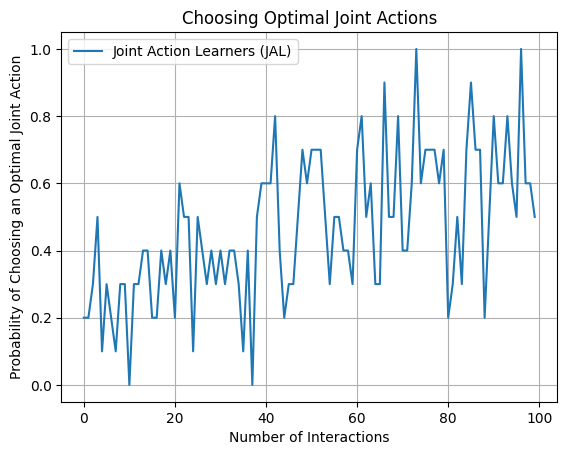

In [7]:
# Plot the results
plt.plot(optimal_action_probs_jal, label='Joint Action Learners (JAL)')
plt.xlabel('Number of Interactions')
plt.ylabel('Probability of Choosing an Optimal Joint Action')
plt.title('Choosing Optimal Joint Actions')
plt.legend()
plt.grid(True)
plt.show()

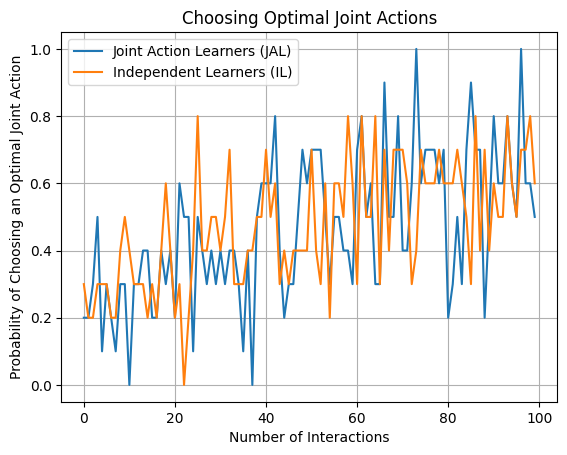

In [8]:
# Now, run the Independent Learner experiment
for trial in range(num_trials):
    # Initialize environment and agents for Independent Learners (ILs)
    env = MatrixGame(reward_matrix=ASYMMETRIC_COORDINATION_GAME)

    agent_0_il = Qlearner(
        action_size=2,
        state_size=1,
        learning_rate=0.0,
        gamma=0.95,
        epsilon=1.0,
        epsilon_min=0.01,
        epsilon_decay=0.99
    )

    agent_1_il = Qlearner(
        action_size=2,
        state_size=1,
        learning_rate=0.0,
        gamma=0.95,
        epsilon=1.0,
        epsilon_min=0.01,
        epsilon_decay=0.99
    )

    # Keep track of the number of optimal actions for each episode
    optimal_actions_il = np.zeros(num_episodes)

    for episode in range(num_episodes):
        observations = env.reset()
        state = 0  # Single state in the Hill-Climbing game

        done = False

        # Agents take actions
        action_0_il = agent_0_il.select_action(state)
        action_1_il = agent_1_il.select_action(state)

        actions = {"player_0": action_0_il, "player_1": action_1_il}

        # Step in the environment
        observations, rewards, dones, _, infos = env.step(actions)

        # Check if the agents selected the optimal joint action
        if (action_0_il, action_1_il) == optimal_joint_action:
            optimal_actions_il[episode] += 1

        # Update Q-tables
        agent_0_il.update(state, action_0_il, state, rewards["player_0"], dones["player_0"])
        agent_1_il.update(state, action_1_il, state, rewards["player_1"], dones["player_1"])

    # Calculate the probability of optimal joint action over episodes for this trial
    optimal_action_probs_il += optimal_actions_il / num_trials  # Averaging across trials

# Plot the results with both JAL and IL
plt.plot(optimal_action_probs_jal, label='Joint Action Learners (JAL)')
plt.plot(optimal_action_probs_il, label='Independent Learners (IL)')
plt.xlabel('Number of Interactions')
plt.ylabel('Probability of Choosing an Optimal Joint Action')
plt.title('Choosing Optimal Joint Actions')
plt.legend()
plt.grid(True)
plt.show()

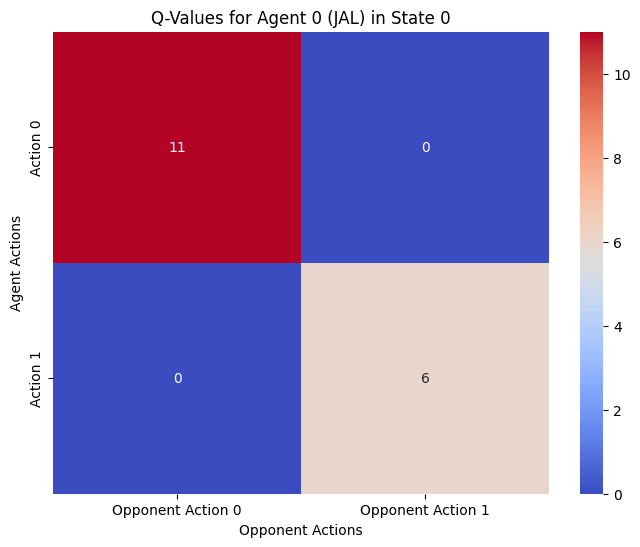

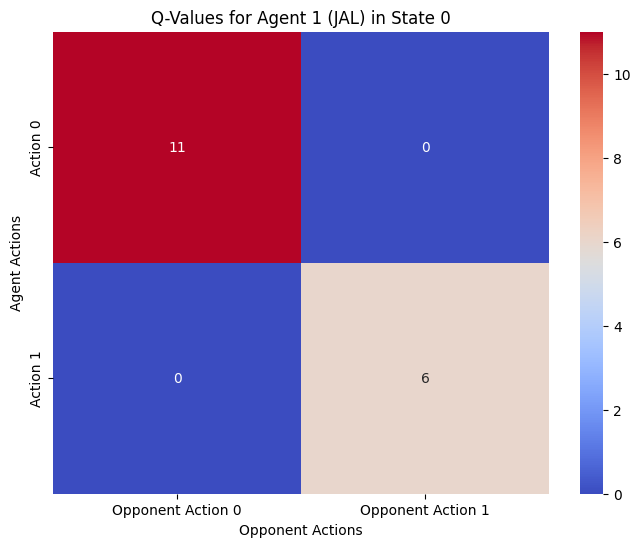

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_q_values_heatmap(agent, agent_name):
    for state in range(agent.state_size):
        plt.figure(figsize=(8, 6))
        q_values = agent.qtable[state]  # Get the Q-values for this state
        sns.heatmap(q_values, annot=True, cmap="coolwarm", cbar=True, xticklabels=[f"Opponent Action {i}" for i in range(agent.opponent_action_size)], yticklabels=[f"Action {i}" for i in range(agent.action_size)])
        plt.title(f"Q-Values for {agent_name} in State {state}")
        plt.xlabel("Opponent Actions")
        plt.ylabel("Agent Actions")
        plt.show()

# Plot heatmaps for both JAL agents
plot_q_values_heatmap(agent_0_jal, "Agent 0 (JAL)")
plot_q_values_heatmap(agent_1_jal, "Agent 1 (JAL)")

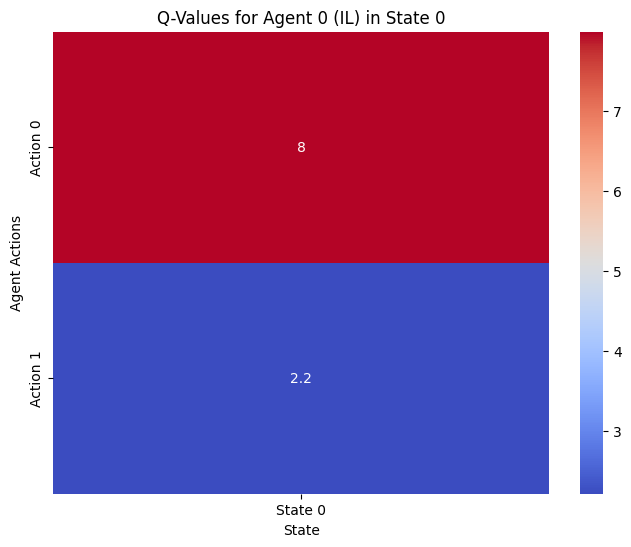

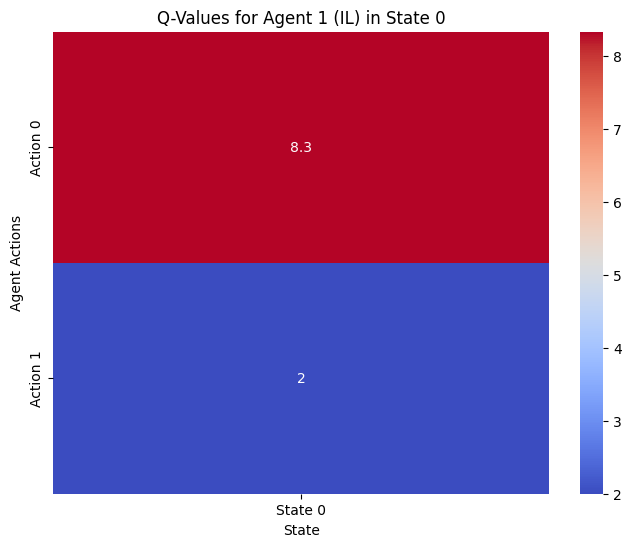

In [10]:
# Plot heatmaps for IL agents:
def plot_q_values_heatmap_il(agent, agent_name):
    for state in range(agent.state_size):
        plt.figure(figsize=(8, 6))
        q_values = agent.qtable[state]  # Get the Q-values for this state
        sns.heatmap(q_values.reshape(-1, 1), annot=True, cmap="coolwarm", cbar=True,
                    yticklabels=[f"Action {i}" for i in range(agent.action_size)],
                    xticklabels=[f"State {state}"])
        plt.title(f"Q-Values for {agent_name} in State {state}")
        plt.xlabel("State")
        plt.ylabel("Agent Actions")
        plt.show()

plot_q_values_heatmap_il(agent_0_il, "Agent 0 (IL)")
plot_q_values_heatmap_il(agent_1_il, "Agent 1 (IL)")

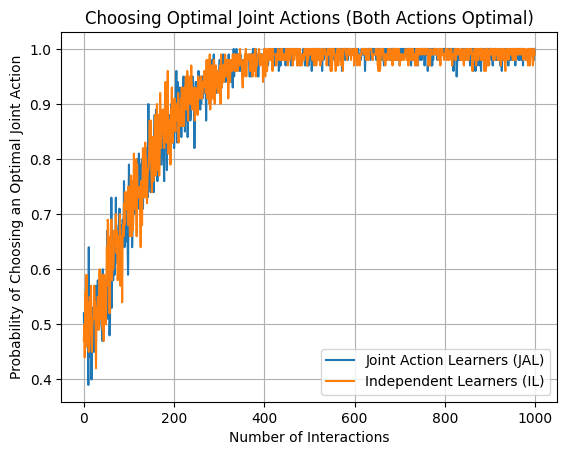

In [11]:
# Both coordinated actions (0, 0) and (1, 1) give reward 10
COORDINATION_MATRIX = np.array([[(10, 10), (0, 0)],  # (0, 0) is optimal
                                  [(0, 0), (10, 10)]])  # (1, 1) is also optimal

import matplotlib.pyplot as plt
import numpy as np

# Number of trial runs
num_trials = 100
num_episodes = 1000

# Store the probability of optimal joint action for each episode, averaged across trials
optimal_action_probs_jal = np.zeros(num_episodes)
optimal_action_probs_il = np.zeros(num_episodes)

# Define the two optimal joint actions
optimal_joint_actions = [(0, 0), (1, 1)]

# Run multiple trial runs for JAL
for trial in range(num_trials):
    # Initialize environment and agents for Joint Action Learners (JALs)
    env = MatrixGame(reward_matrix=COORDINATION_MATRIX)

    agent_0_jal = JointActionLearner(
        action_size=2,
        opponent_action_size=2,
        state_size=1,
        learning_rate=0.0,
        gamma=0.95,
        epsilon=1.0,
        epsilon_min=0.01,
        epsilon_decay=0.99
    )

    agent_1_jal = JointActionLearner(
        action_size=2,
        opponent_action_size=2,
        state_size=1,
        learning_rate=0.0,
        gamma=0.95,
        epsilon=1.0,
        epsilon_min=0.01,
        epsilon_decay=0.99
    )

    # Keep track of the number of optimal actions for each episode
    optimal_actions_jal = np.zeros(num_episodes)

    for episode in range(num_episodes):
        observations = env.reset()
        state = 0  # Single state in the Hill-Climbing game

        done = False

        # Agents take actions
        action_0_jal = agent_0_jal.select_action(state)
        action_1_jal = agent_1_jal.select_action(state)

        actions = {"player_0": action_0_jal, "player_1": action_1_jal}

        # Step in the environment
        observations, rewards, dones, _, infos = env.step(actions)

        # Check if the agents selected one of the optimal joint actions
        if (action_0_jal, action_1_jal) in optimal_joint_actions:
            optimal_actions_jal[episode] += 1

        # Update the Q-tables
        agent_0_jal.update(state, action_0_jal, action_1_jal, state, rewards["player_0"], dones["player_0"])
        agent_1_jal.update(state, action_1_jal, action_0_jal, state, rewards["player_1"], dones["player_1"])

        # Update belief about the opponent's strategy
        agent_0_jal.update_opponent_distribution(action_1_jal)
        agent_1_jal.update_opponent_distribution(action_0_jal)

    # Calculate the probability of optimal joint action over episodes for this trial
    optimal_action_probs_jal += optimal_actions_jal / num_trials  # Averaging across trials


# Now, run the Independent Learner (IL) experiment
for trial in range(num_trials):
    # Initialize environment and agents for Independent Learners (ILs)
    env = MatrixGame(reward_matrix=COORDINATION_MATRIX)

    agent_0_il = Qlearner(
        action_size=2,
        state_size=1,
        learning_rate=0.0,
        gamma=0.95,
        epsilon=1.0,
        epsilon_min=0.01,
        epsilon_decay=0.99
    )

    agent_1_il = Qlearner(
        action_size=2,
        state_size=1,
        learning_rate=0.0,
        gamma=0.95,
        epsilon=1.0,
        epsilon_min=0.01,
        epsilon_decay=0.99
    )

    # Keep track of the number of optimal actions for each episode
    optimal_actions_il = np.zeros(num_episodes)

    for episode in range(num_episodes):
        observations = env.reset()
        state = 0  # Single state in the Hill-Climbing game

        done = False

        # Agents take actions
        action_0_il = agent_0_il.select_action(state)
        action_1_il = agent_1_il.select_action(state)

        actions = {"player_0": action_0_il, "player_1": action_1_il}

        # Step in the environment
        observations, rewards, dones, _, infos = env.step(actions)

        # Check if the agents selected one of the optimal joint actions
        if (action_0_il, action_1_il) in optimal_joint_actions:
            optimal_actions_il[episode] += 1

        # Update Q-tables
        agent_0_il.update(state, action_0_il, state, rewards["player_0"], dones["player_0"])
        agent_1_il.update(state, action_1_il, state, rewards["player_1"], dones["player_1"])

    # Calculate the probability of optimal joint action over episodes for this trial
    optimal_action_probs_il += optimal_actions_il / num_trials  # Averaging across trials

# Plot the results with both JAL and IL
plt.plot(optimal_action_probs_jal, label='Joint Action Learners (JAL)')
plt.plot(optimal_action_probs_il, label='Independent Learners (IL)')
plt.xlabel('Number of Interactions')
plt.ylabel('Probability of Choosing an Optimal Joint Action')
plt.title('Choosing Optimal Joint Actions (Both Actions Optimal)')
plt.legend()
plt.grid(True)
plt.show()

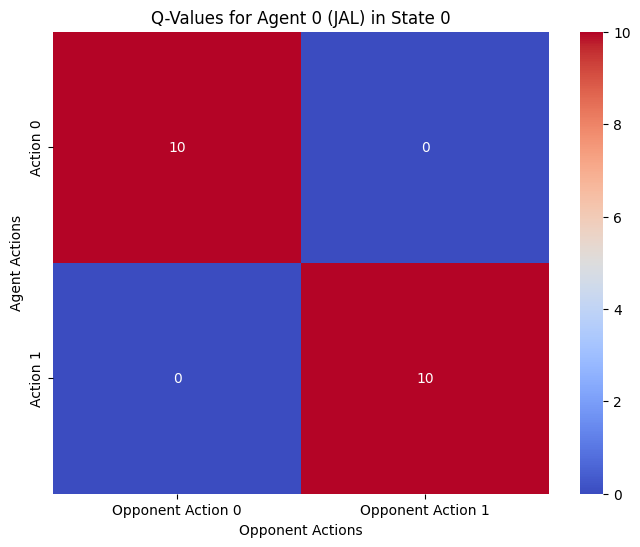

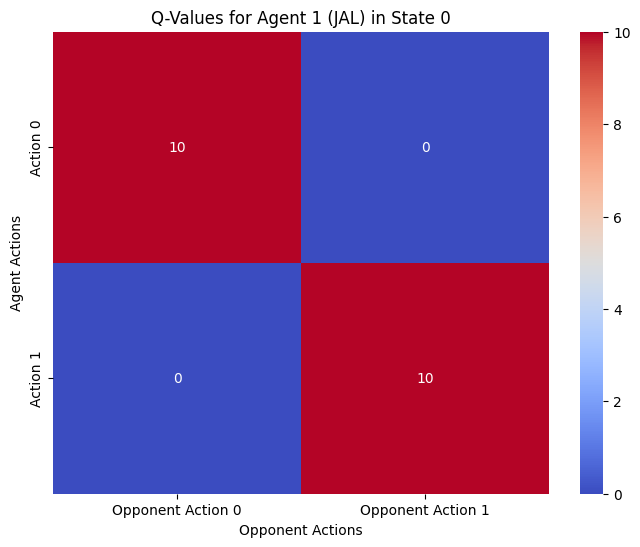

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_q_values_heatmap(agent, agent_name):
    for state in range(agent.state_size):
        plt.figure(figsize=(8, 6))
        q_values = agent.qtable[state]  # Get the Q-values for this state
        sns.heatmap(q_values, annot=True, cmap="coolwarm", cbar=True, xticklabels=[f"Opponent Action {i}" for i in range(agent.opponent_action_size)], yticklabels=[f"Action {i}" for i in range(agent.action_size)])
        plt.title(f"Q-Values for {agent_name} in State {state}")
        plt.xlabel("Opponent Actions")
        plt.ylabel("Agent Actions")
        plt.show()

# Plot heatmaps for both JAL agents
plot_q_values_heatmap(agent_0_jal, "Agent 0 (JAL)")
plot_q_values_heatmap(agent_1_jal, "Agent 1 (JAL)")

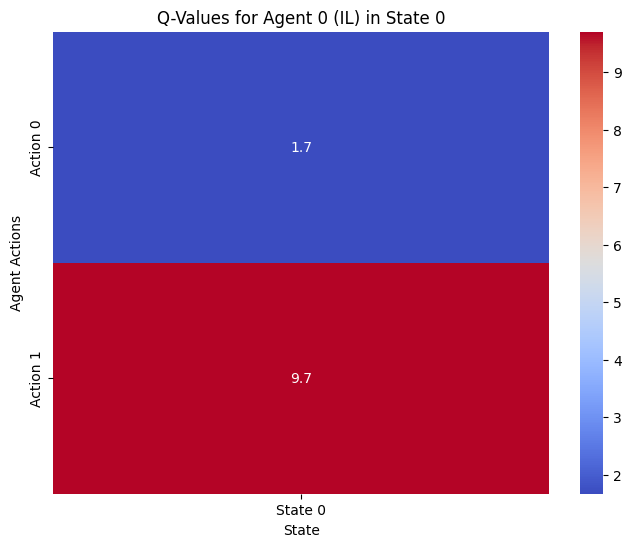

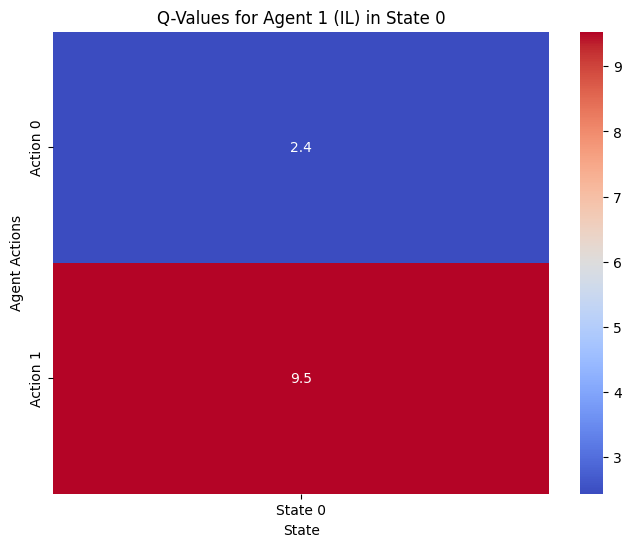

In [13]:
# Plot heatmaps for IL agents:
def plot_q_values_heatmap_il(agent, agent_name):
    for state in range(agent.state_size):
        plt.figure(figsize=(8, 6))
        q_values = agent.qtable[state]  # Get the Q-values for this state
        sns.heatmap(q_values.reshape(-1, 1), annot=True, cmap="coolwarm", cbar=True,
                    yticklabels=[f"Action {i}" for i in range(agent.action_size)],
                    xticklabels=[f"State {state}"])
        plt.title(f"Q-Values for {agent_name} in State {state}")
        plt.xlabel("State")
        plt.ylabel("Agent Actions")
        plt.show()

plot_q_values_heatmap_il(agent_0_il, "Agent 0 (IL)")
plot_q_values_heatmap_il(agent_1_il, "Agent 1 (IL)")

In [14]:
from gymnasium import spaces
from pettingzoo import ParallelEnv

import numpy as np

class StochasticGame(ParallelEnv):  # also use from pettingzoo
    metadata = {'render_modes': ['human']}

    def __init__(self, reward_matrix, standard_deviations):
        self.agents = ["player_0", "player_1", "player_2"]
        self.possible_agents = self.agents[:]
        self.reward_matrix = reward_matrix
        self.standard_deviations = standard_deviations

        self.action_spaces = {agent: spaces.Discrete(reward_matrix.shape[0]) for agent in self.agents}
        self.observation_spaces = {agent: spaces.Discrete(1) for agent in self.agents}

    def reset(self, seed=None, options=None):
        self.agents = self.possible_agents[:]
        self.rewards = {agent: 0.0 for agent in self.agents}
        self.dones = {agent: False for agent in self.agents}
        self.infos = {agent: {} for agent in self.agents}
        self.state = None  # Stateless environment

        return {agent: 0 for agent in self.agents}  # Observations are dummy since the environment is stateless

    def step(self, actions):
        if not self.agents:
            return

        # Extract actions
        action_0 = actions[self.agents[0]]
        action_1 = actions[self.agents[1]]
        action_2 = actions[self.agents[2]]

        # Get rewards from the reward matrix
        #print("actions", action_0, action_1, action_2)
        rewards_0, rewards_1, rewards_2 = self.get_rewards_for_actions(action_0, action_1, action_2)
        #print("rewards", rewards_0, rewards_1, rewards_2)

        # Update rewards
        self.rewards = {self.agents[0]: rewards_0, self.agents[1]: rewards_1, self.agents[2]: rewards_2}

        # Since this is a one-shot game, mark agents as done
        self.dones = {agent: True for agent in self.agents}
        self.truncateds = {agent: False for agent in self.agents}

        # No additional info in this case
        self.infos = {agent: {} for agent in self.agents}

        # Observations are dummy since the environment is stateless
        observations = {agent: 0 for agent in self.agents}

        return observations, self.rewards, self.dones, self.truncateds, self.infos

    def get_rewards_for_actions(self, action_0, action_1, action_2):
        mean = self.reward_matrix[action_0, action_1, action_2]
        sigma = self.standard_deviations.get_sigma(action_1, action_2)

        # normal distribution with mean and sigma
        return mean + np.random.normal(0, sigma, 3)

    def render(self):
        pass

    def close(self):
        pass


class StandardDeviation:
    def __init__(self, sigma0, sigma1, sigma):
        self.sigma0 = sigma0
        self.sigma1 = sigma1
        self.sigma = sigma

    def get_sigma(self, action_b, action_c):
        """
        Get the sigma that is supposed to be application as per our game rules
        """
        if action_b == 0 and action_c == 0:  # Coresponds to joint action <ai, b1, c1>
            return self.sigma0
        elif action_b == 1 and action_c == 1:  # Corresponds to joint action <ai, b2, c2>
            return self.sigma1
        else:  # For all other combinations
            return self.sigma


In [23]:

class BoltzmannJointActionLearner:
    def __init__(
            self,
            action_size,
            opponent_action_size,
            state_size,
            learning_rate=0.0,
            gamma=0.95,
            epsilon=1.0,
            epsilon_min=0.01,
            epsilon_decay=0.995,
            temperature=1.0,
            temperature_min=0.1,
            temperature_decay=0.995,
            agent_name="player",
            decay_factor=0.6 # Quite high since exploration stage will be long, we don't want initial probs to affect later actions too much!
    ):
        self.name = agent_name
        self.action_size = action_size
        self.opponent_action_size = opponent_action_size
        self.state_size = state_size

        # Initialize Q-table for joint actions (state, own action, opponent1, opponent2)
        self.qtable = np.zeros(
            (self.state_size, self.action_size, self.opponent_action_size, self.opponent_action_size))

        # Track each opponent's actions separately
        self.opponent1_action_counts = np.zeros(self.opponent_action_size)
        self.opponent2_action_counts = np.zeros(self.opponent_action_size)

        self.opponent1_action_distribution = np.ones(self.opponent_action_size) / self.opponent_action_size
        self.opponent2_action_distribution = np.ones(self.opponent_action_size) / self.opponent_action_size

        self.decay_factor = decay_factor

        # Learning rate setup
        if learning_rate == 0.0:
            self.dynamic_lr = True
            self.action_counter = np.zeros(
                (self.state_size, self.action_size, self.opponent_action_size, self.opponent_action_size))
        else:
            self.dynamic_lr = False
            self.learning_rate = learning_rate

        # Parameters for exploration and Boltzmann action selection
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.temperature = temperature
        self.temperature_min = temperature_min
        self.temperature_decay = temperature_decay

        # Tracking rewards and progress
        self.rewards_this_episode = []
        self.episode_total_rewards = []
        self.average_episode_total_rewards = []

        self.state_history = []
        self.action_history = []
        self.opponent1_action_history = []
        self.opponent2_action_history = []

    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            action = random.randrange(self.action_size)
            #print(f"Randomly selected action: {action}")
        else:
            # Compute joint distribution as the outer product of individual distributions

            ## THIS IS WHERE THE PROBLEM OCCURS

            joint_distribution = np.outer(self.opponent1_action_distribution, self.opponent2_action_distribution)
            # print(f"Opponent1 Distribution: {self.opponent1_action_distribution*100}")
            # print(f"Opponent2 Distribution: {self.opponent2_action_distribution*100}")
            # print(f"Joint Distribution:\n{joint_distribution*100}")

            # Calculate expected Q-values for each of the agent's actions
            expected_q_values = np.sum(
                self.qtable[state] * joint_distribution,
                axis=(1, 2)
            )
            # print(f"Q-table at state {state}:\n{self.qtable[state]}")
            # print(f"Expected Q-values: {expected_q_values}")

            # Select the action with the highest expected Q-value
            """max_q = np.max(expected_q_values)
            max_actions = np.flatnonzero(expected_q_values == max_q)
            # print(f"Max Actions: {max_actions}")
            action = np.random.choice(max_actions)  # Break ties randomly
            """
            max_q_value = np.max(expected_q_values)  # For numerical stability
            exp_q_values = np.exp((expected_q_values - max_q_value) / self.temperature)
            action_probabilities = exp_q_values / np.sum(exp_q_values)
            # print(f"Action probabilities after softmax for {self.name}: {action_probabilities}")

            # Sample an action based on the Boltzmann distribution
            action = np.random.choice(self.action_size, p=action_probabilities)
            # print(f"Greedy selected action: {action}")

        self.state_history.append(state)
        self.action_history.append(action)
        return action

    def select_action_new_old(self, state):
        if np.random.rand() < self.epsilon:
            action = random.randrange(self.action_size)
        else:
            # Sample opponent actions directly from their distributions
            opponent1_action = np.random.choice(self.opponent_action_size, p=self.opponent1_action_distribution)
            opponent2_action = np.random.choice(self.opponent_action_size, p=self.opponent2_action_distribution)

            # Use the sampled opponent actions to compute expected Q-values
            expected_q_values = self.qtable[state, :, opponent1_action, opponent2_action]

            # Select the action with the highest expected Q-value
            max_q = np.max(expected_q_values)
            max_actions = np.flatnonzero(expected_q_values == max_q)
            action = np.random.choice(max_actions)  # Break ties randomly

        self.state_history.append(state)
        self.action_history.append(action)
        return action

    def select_action_old(self, state):
        if np.random.rand() < self.epsilon:
            action = random.randrange(self.action_size)
            # print(f"Randomly selected action: {action}")
        else:
            # Compute joint distribution as the outer product of individual distributions
            joint_distribution = np.outer(self.opponent1_action_distribution, self.opponent2_action_distribution)
            # print(f"ACTION SELECTION for {self.name}:")
            # print(f"Opponent1 Distribution: {self.opponent1_action_distribution}")
            # print(f"Opponent2 Distribution: {self.opponent2_action_distribution}")
            # print(f"Joint Distribution:\n{joint_distribution}")

            # Calculate expected Q-values for each of the agent's actions

            # print(f"Q-table at state {state}:\n{self.qtable[state]}")
            expected_q_values = np.sum(
                self.qtable[state] * joint_distribution,
                axis=(1, 2)
            )
            # print(f"Expected Q-values before softmax: {expected_q_values}")

            # Apply Boltzmann (softmax) to the expected Q-values
            max_q_value = np.max(expected_q_values)  # For numerical stability
            exp_q_values = np.exp((expected_q_values - max_q_value) / self.temperature)
            action_probabilities = exp_q_values / np.sum(exp_q_values)
            # print(f"Action probabilities after softmax for {self.name}: {action_probabilities}")

            # Sample an action based on the Boltzmann distribution
            action = np.random.choice(self.action_size, p=action_probabilities)
            # print(f"Selected action for {self.name}: {action}")

        self.state_history.append(state)
        self.action_history.append(action)
        return action

    def update_opponent_distribution(self, opponent1_action, opponent2_action):
        # Update counts for each opponent independently
        self.opponent1_action_history.append(opponent1_action)
        self.opponent2_action_history.append(opponent2_action)

        self.opponent1_action_counts *= self.decay_factor
        self.opponent2_action_counts *= self.decay_factor

        self.opponent1_action_counts[opponent1_action] += 1
        self.opponent2_action_counts[opponent2_action] += 1

        # Update individual action distributions
        self.opponent1_action_distribution = self.opponent1_action_counts / np.sum(self.opponent1_action_counts)
        self.opponent2_action_distribution = self.opponent2_action_counts / np.sum(self.opponent2_action_counts)

    def update(self, state, action, opponent1_action, opponent2_action, new_state, reward, done, update_epsilon=True):
        if not self.dynamic_lr:
            lr = self.learning_rate
        else:
            # Dynamic learning rate for joint actions
            self.action_counter[state, action, opponent1_action, opponent2_action] += 1
            lr = 1 / self.action_counter[state, action, opponent1_action, opponent2_action]
            # print(f"Dynamic Learning Rate: {lr}")

        # Update Q-value for joint actions
        self.qtable[state, action, opponent1_action, opponent2_action] += lr * (
                reward - self.qtable[state, action, opponent1_action, opponent2_action])
        # print(
        #     f"Updated Q-table at state {state}, action {action}, opponent1 {opponent1_action}, opponent2 {opponent2_action}: {self.qtable[state, action, opponent1_action, opponent2_action]}")

        self.rewards_this_episode.append(reward)

        if done:
            episode_reward = self._calculate_episode_reward(self.rewards_this_episode, discount=False)
            self.episode_total_rewards.append(episode_reward)

            k = len(self.average_episode_total_rewards) + 1
            self._calculate_average_episode_reward(k, episode_reward)

            if update_epsilon:
                self.update_epsilon()

            # Reset rewards
            self.rewards_this_episode = []

        self.update_temperature()

    def update_temperature(self):
        self.temperature *= self.temperature_decay
        self.temperature = max(self.temperature_min, self.temperature)
        # print(f"Updated Temperature: {self.temperature}")

    def _calculate_episode_reward(self, rewards_this_episode, discount=False):
        if discount:
            return sum([self.gamma ** i * reward for i, reward in enumerate(rewards_this_episode)])
        return sum(rewards_this_episode)

    def _calculate_average_episode_reward(self, k, episode_reward):
        if k > 1:  # running average is more efficient:
            average_episode_reward = (1 - 1 / k) * self.average_episode_total_rewards[-1] + episode_reward / k
        else:
            average_episode_reward = episode_reward
        self.average_episode_total_rewards.append(average_episode_reward)
        # print(f"Average Episode Reward after {k} episodes: {average_episode_reward}")

    def update_epsilon(self):
        self.epsilon *= self.epsilon_decay
        self.epsilon = max(self.epsilon_min, self.epsilon)
        # print(f"Updated Epsilon: {self.epsilon}")

    def print_rewards(self, episode, print_epsilon=True, print_q_table=True):
        print("*****\nAGENT ", self.name)
        print("Total (discounted) reward of this episode: ", self.episode_total_rewards[episode])
        print("Average total reward over all episodes until now: ", self.average_episode_total_rewards[-1])

        if print_epsilon:
            print("Epsilon:", self.epsilon)
        if print_q_table:
            print("Q-table:", self.qtable)
        print("Temperature:", self.temperature)

In [24]:
STOCHASTIC_GAME_REWARDS_POSITIVE_ONLY = np.array([
    [[11, 30, 0], 
     [30, 7, 6],  
     [0, 0, 5]],  

    [[11, 3, 0],  
     [3, 7, 6],  
     [0, 0, 5]], 

    [[14, 50, 0],
     [50, 4, 3], 
     [0, 0, 3]]  
])

STOCHASTIC_GAME_REWARDS = np.array([
    [[11, -30, 0],
     [-30, 7, 6], 
     [0, 0, 5]],  
    
    [[11, -3, 0], 
     [-3, 7, 6],
     [0, 0, 5]],

    [[14, -50, 0],
     [-50, 4, 3],
     [0, 0, 3]]
])


STOCHASTIC_GAME_REWARDS_SMALL_NEGATIVE = np.array([
    [[11, -3, 0],
     [-3, 7, 6], 
     [0, 0, 5]],  
    
    [[11, -3, 0], 
     [-3, 7, 6],
     [0, 0, 5]],

    [[14, -5, 0],
     [-5, 4, 3],
     [0, 0, 3]]
])

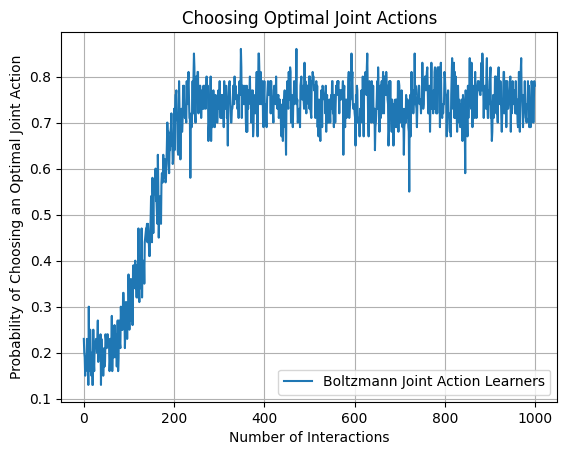

In [28]:
# Number of trial runs
num_trials = 100
num_episodes = 1000
# Store the probability of optimal joint action for each episode, averaged across trials
optimal_action_probs_boltzmann = np.zeros(num_episodes)

optimal_joint_actions = [(2, 0, 0), (1, 0, 0), (1, 1, 0), (1, 1, 1), (0, 1, 1)] # positive values

rewards_so_far = []

# Run trial runs for Boltzmann Joint Action Learner
for trial in range(num_trials):

    # Initialize environment and agents for Joint Action Learners (JALs)
    standard_deviations = StandardDeviation(sigma0=0, sigma1=0, sigma=0)

    env = StochasticGame(reward_matrix=STOCHASTIC_GAME_REWARDS, standard_deviations=standard_deviations)

    agent_0_boltzmann = BoltzmannJointActionLearner(
        action_size=3,
        opponent_action_size=3,
        state_size=1,
        learning_rate=0.0,
        gamma=0.95,
        epsilon=1.0,
        epsilon_min=0.1,
        epsilon_decay=0.99,
        temperature=1.0,
        temperature_min=0.1,
        temperature_decay=0.99,
        agent_name="Agent 0"
    )

    agent_1_boltzmann = BoltzmannJointActionLearner(
        action_size=3,
        opponent_action_size=3,
        state_size=1,
        learning_rate=0.0,
        gamma=0.95,
        epsilon=1.0,
        epsilon_min=0.1,
        epsilon_decay=0.99,
        temperature=1.0,
        temperature_min=0.1,
        temperature_decay=0.99,
        agent_name="Agent 1"
    )

    agent_2_boltzmann = BoltzmannJointActionLearner(
        action_size=3,
        opponent_action_size=3,
        state_size=1,
        learning_rate=0.0,
        gamma=0.95,
        epsilon=1.0,
        epsilon_min=0.1,
        epsilon_decay=0.99,
        temperature=1.0,
        temperature_min=0.1,
        temperature_decay=0.99,
        agent_name="Agent 2"
    )

    # Keep track of the number of optimal actions for each episode
    optimal_actions_boltzmann = np.zeros(num_episodes)

    for episode in range(num_episodes):
        observations = env.reset()
        state = 0
        done = False

        while not done:
            # Agents take actions
            action_0_boltzmann = agent_0_boltzmann.select_action(state)
            action_1_boltzmann = agent_1_boltzmann.select_action(state)
            action_2_boltzmann = agent_2_boltzmann.select_action(state)

            actions = {"player_0": action_0_boltzmann, "player_1": action_1_boltzmann, "player_2": action_2_boltzmann}

            # Step in the environment
            observations, rewards, dones, _, infos = env.step(actions)

            # Update the Q-tables
            agent_0_boltzmann.update(state, action_0_boltzmann, action_1_boltzmann, action_2_boltzmann, state,
                                     rewards["player_0"], dones["player_0"], update_epsilon=True)
            agent_1_boltzmann.update(state, action_1_boltzmann, action_0_boltzmann, action_2_boltzmann, state,
                                     rewards["player_1"], dones["player_1"], update_epsilon=True)
            agent_2_boltzmann.update(state, action_2_boltzmann, action_0_boltzmann, action_1_boltzmann, state,
                                     rewards["player_2"], dones["player_2"], update_epsilon=True)

            # Update opponent distributions
            agent_0_boltzmann.update_opponent_distribution(action_1_boltzmann, action_2_boltzmann)
            agent_1_boltzmann.update_opponent_distribution(action_0_boltzmann, action_2_boltzmann)
            agent_2_boltzmann.update_opponent_distribution(action_0_boltzmann, action_1_boltzmann)

            # Check if the agents selected the optimal joint action
            if (action_0_boltzmann, action_1_boltzmann, action_2_boltzmann) in optimal_joint_actions:
                optimal_actions_boltzmann[episode] += 1

            # Update temperature after each interaction if desired
            # Alternatively, update after each episode

            # Move to the next state if applicable
            state = observations  # Update if your environment provides the next state

            # Check if the episode is done
            done = dones["player_0"] and dones["player_1"] and dones["player_2"]

            # Update temperature after each episode
            agent_0_boltzmann.update_temperature()
            agent_1_boltzmann.update_temperature()
            agent_2_boltzmann.update_temperature()

            """
            if trial == num_trials-1 and episode == num_episodes-1:
                agent_0_boltzmann.print_rewards(episode)
                agent_1_boltzmann.print_rewards(episode)
                agent_2_boltzmann.print_rewards(episode)
            """

            # keep track of actions chosen by the agents and plot them\
            rewards_this_cycle = (action_0_boltzmann, action_1_boltzmann, action_2_boltzmann)
            rewards_so_far.append(rewards_this_cycle)


    # Calculate the probability of optimal joint action over episodes for this trial
    optimal_action_probs_boltzmann += optimal_actions_boltzmann / num_trials  # Averaging across trials


# Plot the results with JAL for 3 agents
plt.plot(optimal_action_probs_boltzmann, label='Boltzmann Joint Action Learners')
plt.xlabel('Number of Interactions')
plt.ylabel('Probability of Choosing an Optimal Joint Action')
plt.title('Choosing Optimal Joint Actions')
plt.legend()
plt.grid(True)
plt.show()

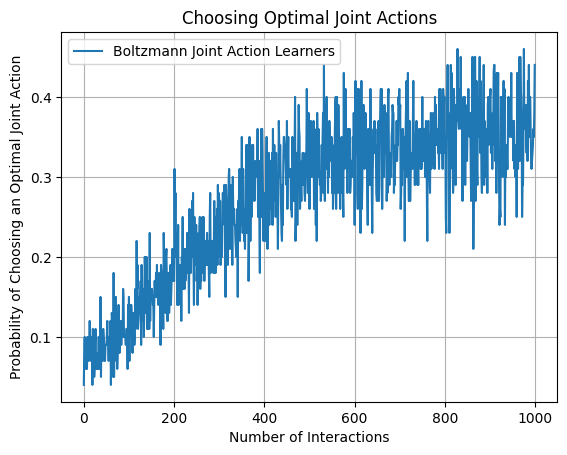

In [18]:
"""Exact same code to run, except switched to using
STOCHASTIC_GAME_REWARDS_POSTITIVE_ONLY reward matrix + optimal_joint_actions"""

# Number of trial runs
num_trials = 100
num_episodes = 1000
# Store the probability of optimal joint action for each episode, averaged across trials
optimal_action_probs_boltzmann = np.zeros(num_episodes)

optimal_joint_actions = [(2, 0, 1), (2, 1, 0)] # I think!

rewards_so_far_positive = []

# Run trial runs for Boltzmann Joint Action Learner
for trial in range(num_trials):

    # Initialize environment and agents for Joint Action Learners (JALs)
    standard_deviations = StandardDeviation(sigma0=2, sigma1=2, sigma=2)

    env = StochasticGame(reward_matrix=STOCHASTIC_GAME_REWARDS_POSITIVE_ONLY, standard_deviations=standard_deviations)

    agent_0_boltzmann = BoltzmannJointActionLearner(
        action_size=3,
        opponent_action_size=3,
        state_size=1,
        learning_rate=0.0,
        gamma=0.95,
        epsilon=1.0,
        epsilon_min=0.01,
        epsilon_decay=0.99,
        temperature=1.0,
        temperature_min=0.1,
        temperature_decay=0.995,
        agent_name="Agent 0"
    )

    agent_1_boltzmann = BoltzmannJointActionLearner(
        action_size=3,
        opponent_action_size=3,
        state_size=1,
        learning_rate=0.0,
        gamma=0.95,
        epsilon=1.0,
        epsilon_min=0.01,
        epsilon_decay=0.99,
        temperature=1.0,
        temperature_min=0.1,
        temperature_decay=0.995,
        agent_name="Agent 1"
    )

    agent_2_boltzmann = BoltzmannJointActionLearner(
        action_size=3,
        opponent_action_size=3,
        state_size=1,
        learning_rate=0.0,
        gamma=0.95,
        epsilon=1.0,
        epsilon_min=0.01,
        epsilon_decay=0.99,
        temperature=1.0,
        temperature_min=0.1,
        temperature_decay=0.995,
        agent_name="Agent 2"
    )

    # Keep track of the number of optimal actions for each episode
    optimal_actions_boltzmann = np.zeros(num_episodes)

    for episode in range(num_episodes):
        observations = env.reset()
        state = 0
        done = False

        while not done:
            # Agents take actions
            action_0_boltzmann = agent_0_boltzmann.select_action(state)
            action_1_boltzmann = agent_1_boltzmann.select_action(state)
            action_2_boltzmann = agent_2_boltzmann.select_action(state)

            actions = {"player_0": action_0_boltzmann, "player_1": action_1_boltzmann, "player_2": action_2_boltzmann}

            # Step in the environment
            observations, rewards, dones, _, infos = env.step(actions)

            # Update the Q-tables
            agent_0_boltzmann.update(state, action_0_boltzmann, action_1_boltzmann, action_2_boltzmann, state,
                                     rewards["player_0"], dones["player_0"], update_epsilon=True)
            agent_1_boltzmann.update(state, action_1_boltzmann, action_0_boltzmann, action_2_boltzmann, state,
                                     rewards["player_1"], dones["player_1"], update_epsilon=True)
            agent_2_boltzmann.update(state, action_2_boltzmann, action_0_boltzmann, action_1_boltzmann, state,
                                     rewards["player_2"], dones["player_2"], update_epsilon=True)

            # Update opponent distributions
            agent_0_boltzmann.update_opponent_distribution(action_1_boltzmann, action_2_boltzmann)
            agent_1_boltzmann.update_opponent_distribution(action_0_boltzmann, action_2_boltzmann)
            agent_2_boltzmann.update_opponent_distribution(action_0_boltzmann, action_1_boltzmann)

            # Check if the agents selected the optimal joint action
            if (action_0_boltzmann, action_1_boltzmann, action_2_boltzmann) in optimal_joint_actions:
                optimal_actions_boltzmann[episode] += 1

            # Update temperature after each interaction if desired
            # Alternatively, update after each episode

            # Move to the next state if applicable
            state = observations  # Update if your environment provides the next state

            # Check if the episode is done
            done = dones["player_0"] and dones["player_1"] and dones["player_2"]

            # Update temperature after each episode
            agent_0_boltzmann.update_temperature()
            agent_1_boltzmann.update_temperature()
            agent_2_boltzmann.update_temperature()

            """
            if trial == num_trials-1 and episode == num_episodes-1:
                agent_0_boltzmann.print_rewards(episode)
                agent_1_boltzmann.print_rewards(episode)
                agent_2_boltzmann.print_rewards(episode)
            """

            # keep track of actions chosen by the agents and plot them\
            rewards_this_cycle = (action_0_boltzmann, action_1_boltzmann, action_2_boltzmann)
            rewards_so_far_positive.append(rewards_this_cycle)


    # Calculate the probability of optimal joint action over episodes for this trial
    optimal_action_probs_boltzmann += optimal_actions_boltzmann / num_trials  # Averaging across trials


# Plot the results with JAL for 3 agents
plt.plot(optimal_action_probs_boltzmann, label='Boltzmann Joint Action Learners')
plt.xlabel('Number of Interactions')
plt.ylabel('Probability of Choosing an Optimal Joint Action')
plt.title('Choosing Optimal Joint Actions')
plt.legend()
plt.grid(True)
plt.show()

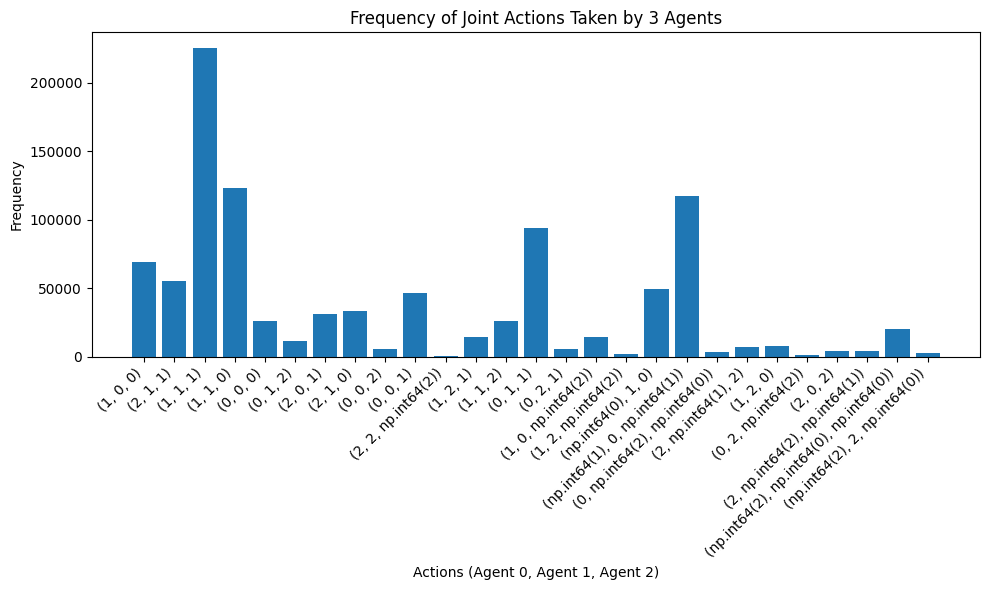

In [19]:
from collections import Counter

action_counts = Counter(rewards_so_far)

# Extract action tuples and their frequencies
actions = list(action_counts.keys())
frequencies = list(action_counts.values())

# Create a bar chart
plt.figure(figsize=(10, 6))

# Convert tuple actions to string for labeling
action_labels = [str(action) for action in actions]

plt.bar(action_labels, frequencies)

# Add labels and title
plt.xlabel('Actions (Agent 0, Agent 1, Agent 2)')
plt.ylabel('Frequency')
plt.title('Frequency of Joint Actions Taken by 3 Agents')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()


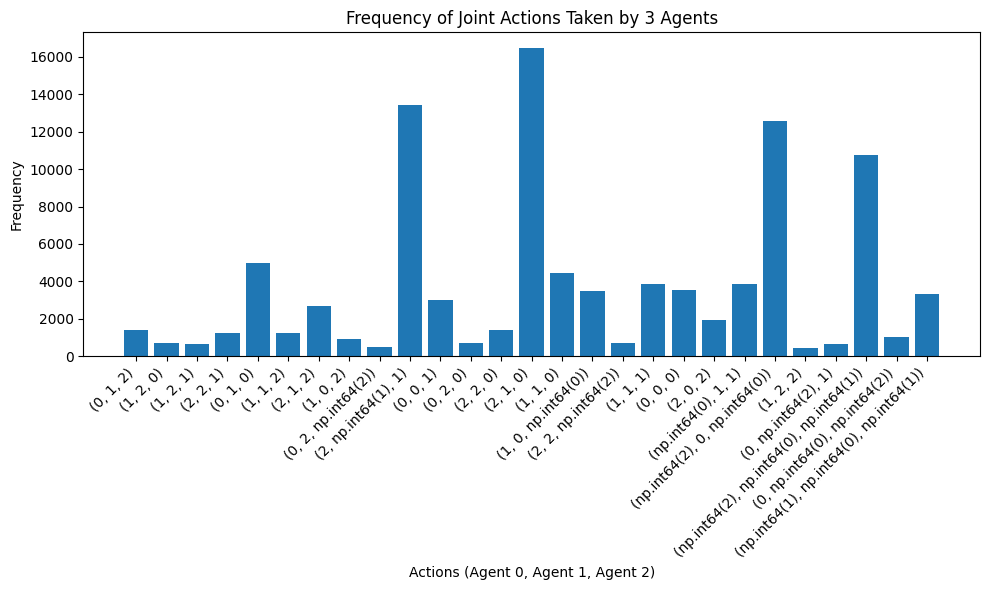

In [20]:
action_counts = Counter(rewards_so_far_positive)

# Extract action tuples and their frequencies
actions = list(action_counts.keys())
frequencies = list(action_counts.values())

# Create a bar chart
plt.figure(figsize=(10, 6))

# Convert tuple actions to string for labeling
action_labels = [str(action) for action in actions]

plt.bar(action_labels, frequencies)

# Add labels and title
plt.xlabel('Actions (Agent 0, Agent 1, Agent 2)')
plt.ylabel('Frequency')
plt.title('Frequency of Joint Actions Taken by 3 Agents')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()


In [21]:
"""
Independent learner class
"""
import numpy as np
import random

class QLearner3x3x3:
    """Q-learning agent for 3x3x3 stochastic game"""

    def __init__(
        self,
        action_size,
        state_size,
        learning_rate=0.0,
        gamma=0.95,
        epsilon=1.0,
        epsilon_min=0.01,
        epsilon_decay=0.995,
    ):
        self.action_size = action_size
        self.state_size = state_size

        # Initialize the Q-table for independent actions
        self.qtable = np.zeros((self.state_size, self.action_size))

        # Define learning rate:
        if learning_rate == 0.0:
            self.dynamic_lr = True
            self.action_counter = np.zeros((self.state_size, self.action_size))
        else:
            self.dynamic_lr = False
            self.learning_rate = learning_rate

        # Discount factor:
        self.gamma = gamma

        # Exploration parameters:
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

        # Tracking rewards/progress:
        self.rewards_this_episode = []  # During an episode, save every time step's reward
        self.episode_total_rewards = []  # Each episode, sum the rewards, possibly with a discount factor
        self.average_episode_total_rewards = []  # The average (discounted) episode reward to indicate progress

        self.state_history = []
        self.action_history = []

    def reset_agent(self):
        self.qtable = np.zeros((self.state_size, self.action_size))

    def select_greedy(self, state):
        """Selects the action with the highest Q-value for the current state"""
        return np.random.choice(np.flatnonzero(np.isclose(self.qtable[state], self.qtable[state].max())))

    def select_action(self, state):
        """Selects an action using epsilon-greedy exploration strategy"""
        if np.random.rand() < self.epsilon:
            action = random.randrange(self.action_size)
        else:
            action = self.select_greedy(state)
        self.state_history.append(state)
        self.action_history.append(action)
        return action

    def update_epsilon(self):
        """Updates epsilon (exploration rate) after each episode"""
        self.epsilon *= self.epsilon_decay
        self.epsilon = max(self.epsilon_min, self.epsilon)

    def update(self, state, action, new_state, reward, done, update_epsilon=True):
        """Performs the Q-learning update"""
        if not self.dynamic_lr:
            lr = self.learning_rate
        else:
            self.action_counter[state, action] += 1
            lr = 1 / self.action_counter[state, action]

        # Q(s,a) <-- Q(s,a) + learning_rate [R + gamma * max_a' Q(s',a') - Q(s,a)]
        self.qtable[state, action] += lr * (reward + (not done) * self.gamma * np.max(self.qtable[new_state]) - self.qtable[state, action])

        self.rewards_this_episode.append(reward)

        if done:
            # Track total reward:
            episode_reward = self._calculate_episode_reward(self.rewards_this_episode, discount=False)
            self.episode_total_rewards.append(episode_reward)

            k = len(self.average_episode_total_rewards) + 1  # Amount of episodes that have passed
            self._calculate_average_episode_reward(k, episode_reward)

            if update_epsilon:
                self.update_epsilon()

            # Reset the rewards for the next episode:
            self.rewards_this_episode = []

    def _calculate_episode_reward(self, rewards_this_episode, discount=False):
        """Calculates the total reward for the current episode"""
        if discount:
            return sum([self.gamma ** i * reward for i, reward in enumerate(rewards_this_episode)])
        return sum(rewards_this_episode)

    def _calculate_average_episode_reward(self, k, episode_reward):
        """Calculates the average reward over all episodes"""
        if k > 1:  # Running average is more efficient
            average_episode_reward = (1 - 1 / k) * self.average_episode_total_rewards[-1] + episode_reward / k
        else:
            average_episode_reward = episode_reward
        self.average_episode_total_rewards.append(average_episode_reward)

    def print_rewards(self, episode, print_epsilon=True, print_q_table=True):
        """Prints rewards and optionally epsilon and Q-table"""
        print("Total (discounted) reward of this episode: ", self.episode_total_rewards[episode])
        print("Average total reward over all episodes until now: ", self.average_episode_total_rewards[-1])

        if print_epsilon:
            print("Epsilon:", self.epsilon)
        if print_q_table:
            print("Q-table: ", self.qtable)


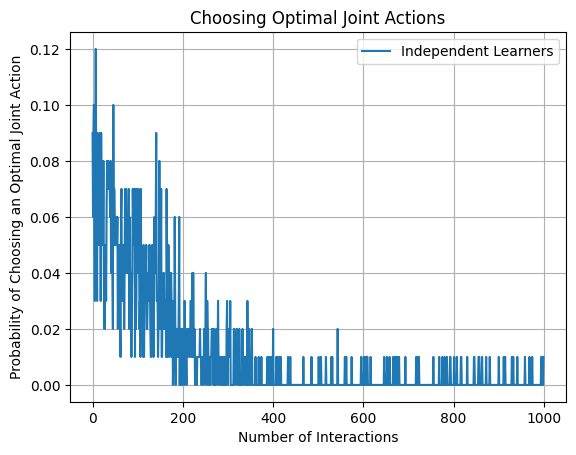

In [22]:
# Number of trial runs
num_trials = 100
num_episodes = 1000
# Store the probability of optimal joint action for each episode, averaged across trials
optimal_action_probs_independent = np.zeros(num_episodes)

optimal_joint_actions = [(2, 0, 1), (2, 1, 0)]  # Define the optimal joint actions

rewards_so_far_positive = []

# Run trial runs for Independent Learners
for trial in range(num_trials):

    # Initialize environment and agents for Independent Learners (ILs)
    standard_deviations = StandardDeviation(sigma0=0, sigma1=0, sigma=0)

    env = StochasticGame(reward_matrix=STOCHASTIC_GAME_REWARDS_SMALL_NEGATIVE, standard_deviations=standard_deviations)

    agent_0_independent = QLearner3x3x3(
        action_size=3,
        state_size=1,
        learning_rate=0.0,
        gamma=0.95,
        epsilon=1.0,
        epsilon_min=0.01,
        epsilon_decay=0.99
    )

    agent_1_independent = QLearner3x3x3(
        action_size=3,
        state_size=1,
        learning_rate=0.0,
        gamma=0.95,
        epsilon=1.0,
        epsilon_min=0.01,
        epsilon_decay=0.99
    )

    agent_2_independent = QLearner3x3x3(
        action_size=3,
        state_size=1,
        learning_rate=0.0,
        gamma=0.95,
        epsilon=1.0,
        epsilon_min=0.01,
        epsilon_decay=0.99
    )

    # Keep track of the number of optimal actions for each episode
    optimal_actions_independent = np.zeros(num_episodes)

    for episode in range(num_episodes):
        observations = env.reset()
        state = 0
        done = False

        while not done:
            # Agents independently take actions
            action_0_independent = agent_0_independent.select_action(state)
            action_1_independent = agent_1_independent.select_action(state)
            action_2_independent = agent_2_independent.select_action(state)

            actions = {"player_0": action_0_independent, "player_1": action_1_independent, "player_2": action_2_independent}

            # Step in the environment
            observations, rewards, dones, _, infos = env.step(actions)

            # Update the Q-tables independently
            agent_0_independent.update(state, action_0_independent, state, rewards["player_0"], dones["player_0"], update_epsilon=True)
            agent_1_independent.update(state, action_1_independent, state, rewards["player_1"], dones["player_1"], update_epsilon=True)
            agent_2_independent.update(state, action_2_independent, state, rewards["player_2"], dones["player_2"], update_epsilon=True)

            # Check if the agents selected the optimal joint action
            if (action_0_independent, action_1_independent, action_2_independent) in optimal_joint_actions:
                optimal_actions_independent[episode] += 1

            # Move to the next state if applicable
            state = observations  # Update if your environment provides the next state

            # Check if the episode is done
            done = dones["player_0"] and dones["player_1"] and dones["player_2"]

            # Keep track of actions chosen by the agents and plot them
            rewards_this_cycle = (action_0_independent, action_1_independent, action_2_independent)
            rewards_so_far_positive.append(rewards_this_cycle)

    # Calculate the probability of optimal joint action over episodes for this trial
    optimal_action_probs_independent += optimal_actions_independent / num_trials  # Averaging across trials


# Plot the results for Independent Learners
plt.plot(optimal_action_probs_independent, label='Independent Learners')
plt.xlabel('Number of Interactions')
plt.ylabel('Probability of Choosing an Optimal Joint Action')
plt.title('Choosing Optimal Joint Actions')
plt.legend()
plt.grid(True)
plt.show()
